<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371D Homework 1

By: Brian Du, Kenneth Marenco, and Zach Star

## Part 1: Predictors

### Problem 1.1 (Exam Style)

**Domain**: The input image is in color. For each one of the values within a pixel (RGB), there will be a value in $B8$ that represents the value of the color. So, the domain for one pixel would be ${B8 x B8 x B8}$. And the entire domain would be: $ 
B8^{100x100x3} $. \
**Codomain**: In a similar fashion, $B1$ would be the base. So the codomain would be $B1^{100x100}$, since there are $100x100$ pixels to be classified.

### Problem 1.2 (Exam Style)

In this example, we can use the zero-one loss function. This loss function gives zero points if the predicted result equals the actual result, and one otherwise. For this problem specifically, if the predictor correctly classifies a pixel as it being either a part of a ground building or not part of a ground building, the predictor's loss function is zero, since it got the answer correct. If it returns a false positive or false negative, the loss is 1, signifying a wrong answer.

Sum across all values  = { 0 if y = y hat { 1 otherwise


$$ (l(y, \hat y ))=   \left\{
\begin{array}{ll}
      0 &  y = \hat y \\
      1 &  otherwise \\
\end{array} 
\right.  $$

### Problem 1.3 (Exam Style)

Formalized definition of domain and codomain, but we only pay attention to one pixel at a time. \
$$ h: B8^3 -> B1$$

### Problem 1.4 (Exam Style)

The model is determined by whatever we choose as our threshold. Once we have treshold, to classify points we plug in input into piecewise function. The piecewise function is as follows:

if v(p) > t {classification of 1 (positive) else {classification of 0 (negative)

The possible values of t are [0,255], since using the max value of r/g/b as 255 and plugging it into v(p) would yield 255 as the max value. The min value similarly yields 0.

### Problem 1.5 (Exam Style)

In 1.1, we classified entire image. In 1.3, we classified one pixel. Sample size for f would be 500, since one image is considered one training sample and we have 500 images. For h, we have 500 x 100 x 100, since each pixel counts as a training sample.

### Problem 1.6 (Exam Style)

$$
P(x,y)= c0 * x^{3} + c1 * y^{3} + c2 * x^{2} y + c3 * xy^{2} + c4 * xy + c5 * x^{2} + c6 * y^{2} + c7 * x + c8 * y + c9 * 1
$$
$$
Q(x, y, z) = c0 * x^2 + c1 * y^2 + c2 * z^2 + c3 * xy + c4 * xz + c5 * yz + c6 * x + c7 * y + c8 * z + c9 * 1
$$

## Part 2: Intuition in Many Dimensions 

In [1]:
import numpy as np
from scipy.special import gamma

d_max = 16
ds = np.arange(1, d_max + 1)
r_exact = np.pi ** (ds/2) / (ds * 2 ** (ds-1) * gamma(ds/2))

### Problem 2.1

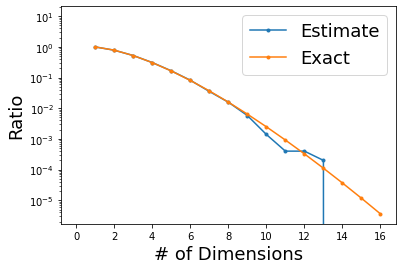

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

def estimate():
    ratios_array = np.zeros(16)
# 16 dimensions
    for i in range(1, 17):
        count = 0
        for n in range(5000):
        # finding the distance in j dimensions
            sq_sum = 0
            for j in range(i):    
                s = np.random.uniform(-1, 1)
                sq_sum += s ** 2
            if (np.sqrt(sq_sum) <= 1):
                count += 1   
        ratios_array[i-1] = count / 5000
    return ratios_array

plt.figure(1)
x_axis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.plot(x_axis, estimate(), marker='.', label="Estimate")
plt.plot(x_axis, r_exact, marker='.', label="Exact")
plt.semilogy(10)
plt.xlabel('# of Dimensions', fontsize=18)
plt.ylabel('Ratio', fontsize=18)
plt.legend(prop={'size': 18})

### Problem 2.2

Estimates of the ratio r(d) become relatively poor in many dimensions.

This has to do with the curse of dimensionality. For the estimate to be accurate, the points that represent the domain that we randomly choose should "fill" the space of the domain nicely; for a single dimension, if 10 equally spaced points are sufficient to cover the domain, two dimensions entail 100, and d dimensions entail 10^d.

For this problem we randomly choose n = 5000 points from the domain space to estimate the ratio. For higher dimensions, these n points may be too sparse to achieve an accurate estimation (i.e. number of points needed for accurate estimation grows with the number of dimensions).

## Part 3: Extrapolation

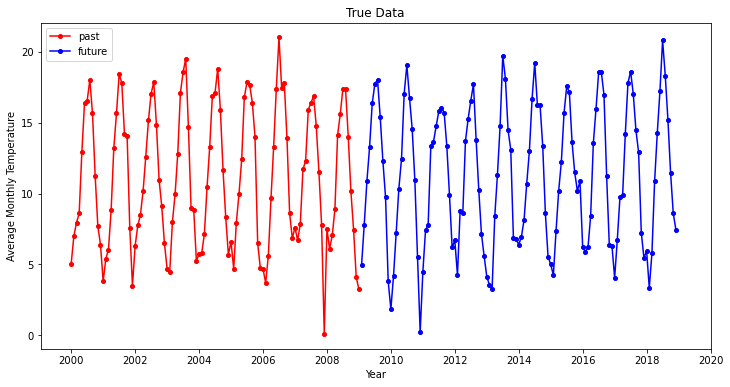

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt
import pickle


file_name = 'temperatures.pkl'
with open(file_name, 'rb') as file:
    temperatures = pickle.load(file)

past_true = temperatures['past']
future_true = temperatures['future']
past_years = past_true['years']
future_years = future_true['years']

plot_size = (12, 6)
plt.figure(figsize=plot_size)
plt.plot(past_years, past_true['y'], label='past',
         color='red', marker='.', markersize=8)
plt.plot(future_years, future_true['y'], label='future',
         color='blue', marker='.', markersize=8)
plt.legend()
plt.xlabel('Year')
plt.xticks(ticks=range(int(min(past_years)), int(max(future_years)) + 3, 2))
plt.ylabel('Average Monthly Temperature')
plt.title('True Data')
plt.show()

### Problem 3.1

In [4]:
def polynomial(k):
    return lambda x: np.power(x, k)


def evaluate_basis(x, basis, K):
    return np.array([basis(j)(x) for j in range(K)]).transpose()


def fit(T, K, basis, normalize=False):
    x = np.array(T['x'])
    max_x = np.max(np.abs(x)) if normalize else 1.
    x /= max_x
    A = evaluate_basis(x, basis, K)
    b = np.array(T['y'])
    return np.linalg.lstsq(A, b, rcond=None)[0], max_x


def expand(x, max_x, coefficients, basis):
    return np.dot(evaluate_basis(x / max_x, basis, len(coefficients)), coefficients)



def show_extrapolation(true_past, est_past, true_future, est_future,
                       title='', figure_size=(12, 4), clip=None):
    def clip_values(y):
        if clip is None:
            z = y
        else:
            z = y.copy()
            z[np.logical_or(y < clip[0], y > clip[1])] = np.nan
        return z

    past_time, future_time = true_past['years'], true_future['years']
    plt.figure(figsize=figure_size)
    plt.plot(past_time, clip_values(true_past['y']),
             label='true past values', color='red', marker='.', markersize=8, ls='')
    plt.plot(past_time, clip_values(est_past),
             label='estimated past values', color='red')
    plt.plot(future_time, clip_values(true_future['y']),
             label='true future values', color='blue', marker='.', markersize=8, ls='')
    plt.plot(future_time, clip_values(est_future),
             label='estimated future values', color='blue')
    plt.legend()
    plt.xlabel('Year')
    plt.xticks(ticks=range(int(min(past_time)), int(max(future_time)) + 3, 2))
    plt.ylabel('Average Monthly Temperature')
    if len(title) > 0:
        plt.title(title)
    plt.show()


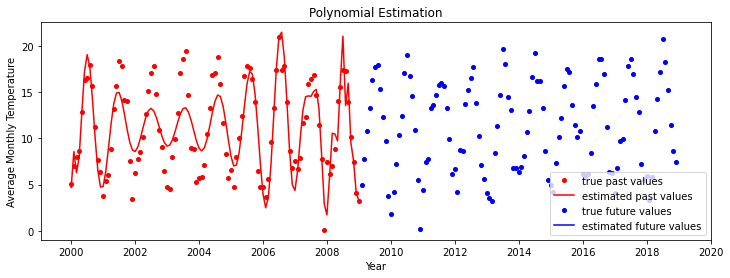

The next two monthly average temperatures are
285345.107421875 6092588.00390625


In [5]:
#print(fit(past_true, 109, polynomial, normalize=True))
predictor_y = expand(past_true['x'], fit(past_true, 109, polynomial, normalize=True)[1], fit(past_true, 109, polynomial, normalize=True)[0], polynomial)
predictor_future = expand(future_true['x'], fit(past_true, 109, polynomial, normalize=True)[1], fit(past_true, 109, polynomial, normalize=True)[0], polynomial)
#print(predictor_y)
show_extrapolation(past_true, predictor_y, future_true, predictor_future, title='Polynomial Estimation', figure_size=(12,4), clip=[-1000, 1000])
print("The next two monthly average temperatures are")
print(predictor_future[0],predictor_future[1])

### Problem 3.2

In [6]:
def temperature_basis(k):
    assert(k>=0 & k<4)
    if k == 3:
        return lambda x: x
        
    if k == 2:
        return lambda x: np.sin(2*np.pi*x/12)
        
    if k == 1: 
        return lambda x: np.cos(2*np.pi*x/12)
        
    if k == 0:
        return lambda x: 1+x-x 
        

(array([ 1.12497475e+01, -6.53591188e+00, -8.33720970e-01, -2.27430643e-03]), 1.0)


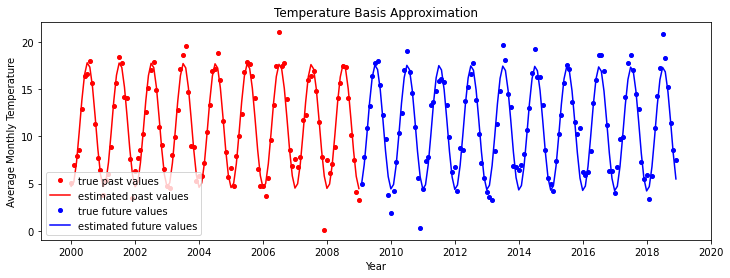

In [7]:
print(fit(past_true, 4, temperature_basis, normalize=False))
past_fitting = expand(past_true['x'], fit(past_true, 4, temperature_basis, normalize=False)[1], fit(past_true, 4, temperature_basis, normalize=False)[0], temperature_basis)
future_predict = expand(future_true['x'], fit(past_true, 4, temperature_basis, normalize=False)[1], fit(past_true, 4, temperature_basis, normalize=False)[0], temperature_basis)
show_extrapolation(past_true, past_fitting, future_true, future_predict, title='Temperature Basis Approximation', figure_size=(12,4), clip=[-1000, 1000])

### Problem 3.3

If we trust the previous experiment, we would have a function for average monthly temperature as \
$$ y(x) = (1.12497475e+01) + (-6.53591188e+00) * cos\biggl( \frac{2 \pi x}{12}\biggr) + (-8.33720970e-01) * sin \biggl( \frac{2 \pi x}{12} \biggr) + (-2.27430643e-03) * x $$  \
This points us towards global cooling because the fourth term is negative meaning as x approaches infinite we will see that the equation, the average monthly temperature, tends towards negative infinite as well.
